# Bayes estimator and bayes risk

## Question 1

On choisit les paramètres suivants :
$$
\begin{aligned}
\mathcal{X} & =\{1, 2, 3\} \\
\mathcal{Y} & =\{0, 1\}
\end{aligned}
$$
$X$ suit une loi uniforme sur $\mathcal{X}$
$$
Y=\left\{\begin{array}{l}
Q(1 / 4) \text { if } X=1 \\
Q(2 / 5) \text { if } X=2 \\
Q(3 / 4) \text { if } X=3
\end{array}\right.
$$
Avec $Q(p)$ un loi de paramètre $p$, telle que :
$$
P(X=x)=\left\{\begin{array}{l}
p \text { if } x=0 \\
1-p \text { if } x=1 \\
0 \text { else }
\end{array}\right.
$$

On choisit la "0-1" loss $l(y, z)=1_{y \neq z}$.  
L'estimateur de Bayes est défini par :
$$
f^*(x)=\arg \min E[l(y, z) \mid X=x]
$$
Ainsi :
$$
\begin{aligned}
f^*(x) & =\arg \min E[l(y, z) \mid X=x] \\
& =\arg \min P(Y \neq z \mid X=x) \\
& =1-\arg \min P(Y=z \mid X=x) \\
& =\arg \max P(Y=z \mid X=x)
\end{aligned}
$$
On obtient:
\begin{aligned}
-f^*(1) & =1 \\
-f^*(2) & =1 \\
-f^*(3) & =0
\end{aligned}

On va calculer le risque de Bayes :
$$
\begin{aligned}
R^*(x) & =E\left[l\left(Y, f^*(X)\right)\right] \\
& =E_X\left[E_Y\left(l\left(Y \neq f^*(X) \mid X\right)\right)\right] \\
& =E_X\left[P\left(Y \neq f^*(X) \mid X\right)\right]
\end{aligned}
$$
Sachant que :
$$
P\left(Y \neq f^*(X) \mid X=x\right)=P\left(Y \neq f^*(x)\right)
$$
On note $\eta(x)=P(Y=0 \mid X=x)$. Then :
- Si $\eta(x)>\frac{1}{2}$, alors $f^*(x)=0$, et $P\left(Y \neq f^*(x)\right)=P(Y=1)=1-\eta(x)$
- Si $\eta(x)<\frac{1}{2}$, alors $f^*(x)=1$, et $P\left(Y \neq f^*(x)\right)=P(Y=0)=\eta(x)$  
ON obtient, $P\left(Y \neq f^*(x)\right)=\min (\eta(x), 1-\eta(x))$.  
Donc
$$
R^*=E_X[\min (\eta(X), 1-\eta(X)]
$$

On applique :
$$
\begin{aligned}
R^* & =\frac{1}{3} *\frac{1}{4}+\frac{1}{3} *\frac{2}{5}+\frac{1}{3} *\frac{1}{4} \\
R^* & =\frac{3}{10}
\end{aligned}
$$

## Question 2

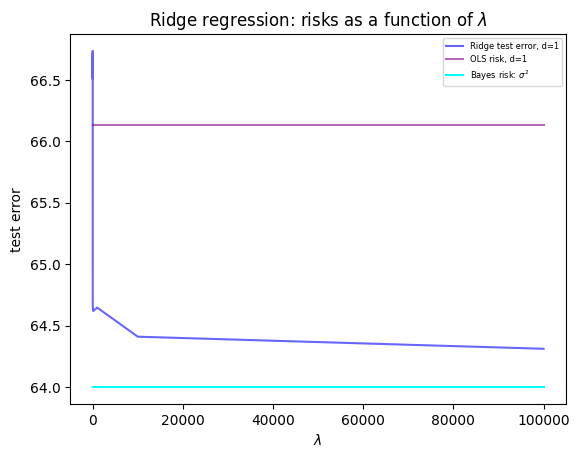

In [3]:
import numpy as np
import matplotlib.pyplot as plt

SIGMA = 8
BAYES_RISK = SIGMA**2

def generate_output_data(
    X: np.ndarray, theta_star, sigma: float, rng, n_tests: int
) -> np.ndarray:
    """
    generate input and output data (supervised learning)
    according to the linear model, fixed design setup
    - X is fixed
    - y is random, according to

    Y = Xtheta_star + epsilon

    We use numpy matrix manipulations in order
    to directly generate a number of output vectors.

    where epsilon is a centered gaussian noise vector with variance
    sigma*In

    Parameters:
        X: (n, d) design matrix
        theta_star
        sigma (float): variance of the noise

    Returns:
        Y (float matrix): output vector (n, 1)
    """
    n = X.shape[0]
    noise = rng.normal(0, sigma, size=(n, n_tests))
    y = theta_star(X) + noise
    return y

def ridge_regression_estimator(
    X: np.ndarray, y: np.ndarray, lambda_: float
) -> np.ndarray:
    """
    Compute the Ridge regression estimator

    We use numpy broadcasting to accelerate computations
    and obtain several Ridge estimators.

    Parameters:
        X: (n, d) matrix
        y: (n, n_tests) matrix
        lambda: regularization parameter

    Returns:
        theta_hat: (d, n_tests) matrix
    """
    n, d = X.shape
    covariance_matrix = X.T @ X
    Sigma_matrix = covariance_matrix / n
    theta_hat = 1 / n * np.linalg.inv(Sigma_matrix + lambda_ * np.identity(d)) @ X.T @ y
    return theta_hat

def q_law(x, p):
    return p if x == 0 else (1 - p if x == 1 else 0)

def bayes_predictor(x):
    if x == 1:
        return 0 if q_law(0, 1/4) > q_law(1, 1/4) else 1
    if x == 2:
        return 0 if q_law(0, 2/5) > q_law(1, 2/5) else 1
    if x == 3:
        return 0 if q_law(0, 3/4) > q_law(1, 3/4) else 1
    
def ridge_risk(n, d, lambda_, n_tests) -> tuple[float, float]:
    """
    Statistical evaluation of the excess risk of the Ridge regression
    estimator

    n_test times, do:
        - Draw output vector Y, according to the linear model, fixed
        design setup.
        - compute the corresponding Ridge estimator
        - generate a test test in order to have an estimation of the excess risk of
        this estimator (generalization error)

    Parameters:
        n (int): number of samples in the dataset
        d (int): dimension of each sample (number of features)
        n_tests (int): number of simulations run

    Returns:
        risk_estimation (float): estimation of the excess risk of the ridge
        estimator in this setup.
    """
    # instantiate a PRNG
    rng = np.random.default_rng()

    # design matrix
    X = np.array([[rng.choice([1, 2, 3]) for _ in range(d)] for _ in range(n)])

    # Bayes predictor
    theta_star = np.vectorize(bayes_predictor)

    # run several simulations to have an estimation of the excess risk
    y = generate_output_data(X, theta_star, SIGMA, rng, n_tests)

    # compute the Ridge regression estimator
    theta_hat = ridge_regression_estimator(X, y, lambda_)

    # generate test data
    y_test = generate_output_data(X, theta_star, SIGMA, rng, n_tests)

    # compute predictions of each OLS estimator
    y_pred = X @ theta_hat

    mean_test_error = np.linalg.norm(y_pred - y_test) ** 2 / (n * n_tests)

    return mean_test_error

def plot_test_errors_ridge(
    risks: dict[tuple, float], d_list: list[int], n: int, lambda_list: list[int]
) -> None:
    """
    Display all the computed risks on a plot
    """
    colors = ["blue", "green", "darkred", "mediumvioletred", "darkmagenta"]
    index = 0

    # plot the risks for each n and d
    for index, d in enumerate(d_list):
        color = colors[index]
        risk_estimates = [risks[d, lambda_] for lambda_ in lambda_list]
        ols_risk = BAYES_RISK + SIGMA**2 * d / n
        alpha = 0.6
        # extended label for the first ont
        label_est = f"Ridge test error, d={d}"
        label_ols = f"OLS risk, d={d}"
        plt.plot(
            lambda_list,
            risk_estimates,
            label=label_est,
            color=color,
            markersize=3,
            alpha=alpha,
        )
        plt.plot(
            lambda_list,
            [ols_risk] * len(lambda_list),
            label=label_ols,
            color="darkmagenta",
            alpha=alpha,
        )

    plt.plot(
        lambda_list,
        [BAYES_RISK] * len(lambda_list),
        label="Bayes risk: " + r"$\sigma^2$",
        color="aqua",
    )

    # finish plot
    plt.xlabel(r"$\lambda$")
    plt.ylabel("test error")
    plt.title(
        "Ridge regression: risks as a function of " + r"$\lambda$"
    )
    plt.legend(loc="best", fontsize=6)

# dimensions of the problem
n_list = [30]
n = 30
# d_list = list(range(0, 1000, 200))
# d_list.remove(0)
d_list = [1]
bayes_risk = 3/10

exponents = [k for k in range(-6, 6)]
lambda_list = [10 ** (u) for u in exponents]

# number of tests to estimate the excess risk
n_tests = int(1e4)

# Assess the influence of different values of n and d
test_errors = dict()
for d in d_list:
    for lambda_ in lambda_list:
        # print(f"lambda: {lambda_}")
        for n in n_list:
            test_errors[(d, lambda_)] = ridge_risk(n, d, lambda_, n_tests)
plot_test_errors_ridge(test_errors, d_list, 30, lambda_list)

Le risque réel est plus faible pour $f^*$ que pour $\tilde{f}$